# Geospatial
Most of the geospatial packages are developed in the JuliaGeo ([Github](https://github.com/JuliaGeo/)) organization, that contains a number of related Julia projects for manipulating, querying, and processing geospatial geometry data. We aim to provide a common interface between geospatial packages. We also have a [website](https://juliageo.org).

We previously presented about JuliaGeo related work in:
- [FOSS4G2019 | JuliaGeo: A Fresh Approach to GeospatialComputing](https://media.ccc.de/v/bucharest-428-juliageo-a-fresh-approach-to-geospatial-computing)
- [JuliaCon2020 | GeoInterface: bringing geospatial packages together](https://www.youtube.com/watch?v=wih_DIWODUs)
- [JuliaCon2022 | State of JuliaGeo](https://www.youtube.com/watch?v=xMRcIpt6Ris)
- [JuliaCon2024 | What’s new with GeoInterface.jl: traits for interoperability](https://www.youtube.com/watch?v=X6UEHg5zjf4)

The geospatial stack is not as mature as others (yet), mostly due to its age as Python and R have had a 20 years headstart. However, it is already easy to install the required C dependencies and read all common data formats into Julia types that can be used across the ecosystem.

In [ ]:
using GeoDataFrames, DataFrames, Rasters, GeoInterface, GeometryOps, Downloads, ArchGDAL, CairoMakie

## Raster data
Let's download and open a small geotiff file. We use `Rasters`, a package inspired by rasterio and xarray in Python.

In [ ]:
using Rasters
raster = Raster("data/srtm.tif")

We can plot this raster using `Makie.jl` (we're using CairoMakie backend here).

In [ ]:
plot(raster; colormap=:deep)

Rasters is built on top of DimensionalData, a way of describing the dimensions of your data, like coordinates, time, bands, etc. This allows for easy indexing and subsetting of data. You might be familiar with this idea from xarray in Python.

In [ ]:
lon = lookup(raster, X) # if X is longitude

We can use these dimensions to subset the raster data.

In [ ]:
@time sub = view(raster, X(-113.2 .. -113.0), Y(37.2 .. 37.5))

This Raster behaves just like any Array in Julia. You can do math with it, or change the type.

In [ ]:
nraster = clamp.(Float32.(raster) * 2, 100, 200)

Saving to file is as easy as reading it

In [ ]:
Rasters.write("test.tif", nraster; force=true)

### From scratch
Conceptually, a raster is an array combined with georeferencing information, whereas the latter comprises:

-   Lookup vectors for the axes, encoding the spatial coordinates for each grid cell.  These take the form of the `X` and `Y` dimensions in the raster that you'll see below.
-   A [coordinate reference system](https://en.wikipedia.org/wiki/Spatial_reference_system) (CRS) definition, specifying the association of the raster's coordinates with the surface of the earth.

Therefore, to create a raster, we first need to have an array with the values, and then supplement it with the georeferencing information.
Let's create `elev`, a $6 \times 6$ array with sequential values from `1` to `36`.
It can be created as follows using base Julia functions.

In [ ]:
elev = reshape(UInt8(1):UInt8(36), (6, 6))

In [ ]:
new_x = X(range(-1.5, step=0.5, length=6))
new_y = Y(range(1.0, step=-0.5, length=6))

In [ ]:
import GeoFormatTypes as GFT
elev_raster = Raster(elev, (new_x, new_y); crs = GFT.EPSG(4326))

In [ ]:
plot(elev_raster)

Rasters can also rasterize geometries, vectorize to points, work on NetCDF files, do zonal statistics and much more. Please check the documentation https://rafaqz.github.io/Rasters.jl/stable/.

## Vector data
We can also easily open vector datasets. We will use GeoDataFrames here, a package inspired by geopandas in Python.

In [ ]:
df = GeoDataFrames.read("data/zion.gpkg")

In [ ]:
plot(df.geometry)

We can also do geometric operations, like `buffer`. Note that we operate independent from the DataFrame, just on a Vector of geometries.

In [ ]:
using LibGEOS, GeometryOps

In [ ]:
plot(GeometryOps.buffer.(df.geometry, 10_000))

The astute reader will note something interesting here. We buffered with `10_000`, but what unit is that? The distance is in the coordinate system, which is in metre here (UTM).

In [ ]:
DataFrames.metadata(df)  # no CRS(!) defined for this geopackage

In [ ]:
GeoInterface.crs(df)

### Proj
Let's use the Proj package to project some data.

In [ ]:
using Proj
pdf = GeometryOps.reproject(df, EPSG(4236), always_xy=true)

In [ ]:
plot(pdf.geometry)

We can ofcourse write this new dataset to file.

In [ ]:
ofn = "output/zion_wgs84.geojson"
GeoDataFrames.write(ofn, pdf; options=Dict("OVERWRITE"=>"YES"))

In [ ]:
String(Base.read(ofn))

In [ ]:
mraster = mask(raster, with=pdf.geometry[1])

In [ ]:
plot(mraster)

### From scratch
We can make geometries from scratch as well. Let's make some points.

In [ ]:
point = GeoInterface.Point(0, 0)

In [ ]:
fig, ax, plt = plot(point)

In [ ]:
x = [-5., 0, 5, 0];
y = [0., -5, 0, 5];
points = GeoInterface.Point.(zip(x,y));
plot!(ax, points; marker = '✈', markersize = 30)
fig

In [ ]:
table = DataFrame(geometry=points, name="test")

In [ ]:
GeoDataFrames.write("custom.gpkg", table; crs=EPSG(4326), layer="points", options=Dict("OVERWRITE"=>"YES"))

---
There are many other *pure* (i.e. not depending on another library like GDAL) Julia readers of such data. For example, the above can be read with GeoJSON.jl. There's also ShapeFile.jl, GeoParquet.jl, GeoArrow.jl and more, if you don't want to use GDAL.

This was just a very short dive into the geospatial ecosystem in Julia. You can learn much more in the documentation of the individual packages https://juliageo.org/GeometryOps.jl/, https://rafaqz.github.io/Rasters.jl/, and https://www.evetion.nl/GeoDataFrames.jl. Meanwhile, there's also:

## Geocomputation with Julia
*very much in progress*

We're writing a book on geospatial analysis in Julia, see https://jl.geocompx.org/! This notebook has been partially derived from the book.

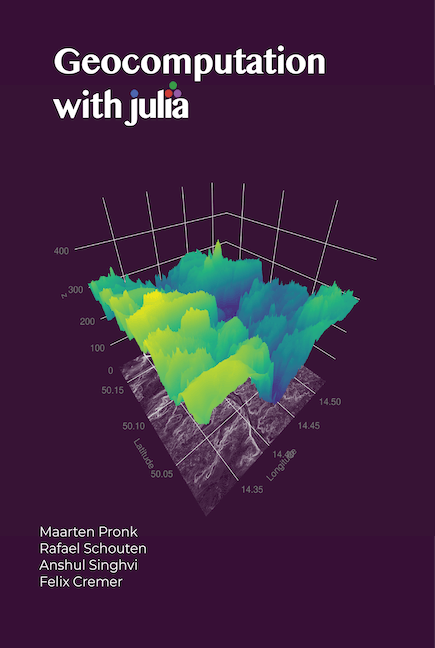